# Acceptance model for B02JpsiKS

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import ROOT
from ROOT import (RooArgSet,
                  RooCategory,
                  RooRealVar,
                  RooDataSet,
                  RooPlot,
                  RooFit,
                  RooStats,
                  RooArgList,
                  RooFormulaVar)

from ROOT import (TFile, 
                  TH1D, 
                  TH2D, 
                  TCanvas, 
                  gStyle, 
                  TLine, 
                  TTree)

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import root_pandas as rp
from root_pandas import read_root
import pandas as pd
            
sys.path.append('/home/vmueller/repos/')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls, build_tchain_from_files
from dopy.doplot.plotting import Plotter, Plot
import dopy.doroot.rootnotes 
from dopy.doplot.selection import add_log_to_dataframe, add_max_to_dataframe, add_min_to_dataframe

In [2]:
dataset_tree_name = 'Bd2JpsiKS'
dataset_file_name = '/fhgfs/groups/e5/lhcb/analysis/B2CC/Bd2JpsiKS_run2/FT_calib/Bd2JpsiKS_final_sw_FTcalibrated_FTcombined_FTcombined.root'

In [3]:
dataset_file = TFile(dataset_file_name)
ROOT.SetOwnership(dataset_file, False)

dataset_tree = dataset_file.Get(dataset_tree_name)
ROOT.SetOwnership(dataset_tree, False) 

In [4]:
cut_string = 'B0_FitPVConst_tau_flat>0.00025&B0_FitPVConst_tau_flat<0.015&B0_FitPVConst_tauErr_flat>-0.001&B0_FitPVConst_tauErr_flat<0.001'
df = rp.read_root(dataset_file_name, key=dataset_tree_name, where=cut_string)

In [5]:
tags = np.array(df['B0_TAGDECISION_OS_new'] )
tagged = 0
untagged = 0
for tag in range(df.shape[0]):
    if tags[tag] == 1 or tags[tag] == -1:
        tagged +=1
    else:
        untagged +=1
tagging_efficiency_OS = tagged / (tagged + untagged)
print(tagging_efficiency_OS)

0.3333536206833591


In [6]:
tags = np.array(df['B0_TAGDECISION_SS_new'] )
tagged_SS = 0
untagged_SS = 0
for tag in range(df.shape[0]):
    if tags[tag] == 1 or tags[tag] == -1:
        tagged_SS +=1
    else:
        untagged_SS +=1
tagging_efficiency_SS = tagged / (tagged + untagged)
print(tagging_efficiency_SS)

0.3333536206833591


In [7]:
mass = RooRealVar("B0_FitDaughtersConst_M_flat","B0_FitDaughtersConst_M_flat",5280,5270,5290)
obsTime     = RooRealVar('B0_FitPVConst_tau_flat', 'obsTime',0.00025, 0.015, 'ns')
obsTimeErr = RooRealVar("B0_FitPVConst_tauErr_flat", "obsTimeErr", 0,-0.001,0.001, "ns")
sweight_sig  = RooRealVar("sweight_sig", "sweight_sig",0 ,-100000,1000000000)
idxPV = RooRealVar("idxPV", "idxPV", 0,0,0)

#Read tagger output 
obsTagOS = RooCategory("B0_TAGDECISION_OS_new", "obsTagOS")
obsTagOS.defineType("B0b", -1)
obsTagOS.defineType("B0",  +1)
obsTagOS.defineType("noTag", 0)
obsTagSS = RooCategory("B0_TAGDECISION_SS_new", "obsTagSS")
obsTagSS.defineType("B0b", -1)
obsTagSS.defineType("B0",  +1)
obsTagSS.defineType("noTag", 0)

obsEtaOS = RooRealVar('B0_TAGOMEGA_OS_new',"obsEtaOS", 0,0.5)
obsEtaSS = RooRealVar('B0_TAGOMEGA_SS_new',"obsEtaSS", 0,0.5)

ROOT.SetOwnership(obsTime, False)
ROOT.SetOwnership(obsTimeErr, False)
ROOT.SetOwnership(sweight_sig, False)
ROOT.SetOwnership(idxPV, False)
ROOT.SetOwnership(obsTagOS, False)
ROOT.SetOwnership(obsTagSS, False)
ROOT.SetOwnership(obsEtaOS, False)
ROOT.SetOwnership(obsEtaSS, False)

data = ROOT.TFile(dataset_file_name)
tree_data = data.Get('Bd2JpsiKS') 
tree_data.GetEntries()
ntupleVarSet =  RooArgSet(obsTime,obsTimeErr,sweight_sig,idxPV,obsTagOS,obsEtaOS)#,obsEtaSS,obsTagSS) 
data = RooDataSet('data','data',ntupleVarSet,RooFit.Import(tree_data), RooFit.WeightVar("sweight_sig"))
ROOT.SetOwnership(data,False)

print('Number of entries: '+ str(data.numEntries()))
data.Print()

Number of entries: 159554


In [8]:
data.isWeighted()

True

In [9]:
subdir = '/home/chasenberg/plots/decaytime'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Build acceptance model

In [10]:
from ROOT import gSystem
gSystem.Load("libRooFit.so")
gSystem.Load("/home/vmueller/repos/dopy/dolib/acceptances/libAcceptances")

0

In [11]:
from ROOT import RooCubicSplineFun
from ROOT import RooResolutionModel 

In [12]:
from ROOT import std
knots = std.vector("double")(5)
knots[0]=(obsTime.getMin()) # 0.0
knots[1]=(0.0003)
knots[2]=(0.0009)
knots[3]=(0.004)
knots[4]=(obsTime.getMax()) 

In [13]:
print(obsTime.getMin(),obsTime.getMax(),len(knots))

0.00025 0.015 5


In [35]:
knotlist = RooArgList("knotlist")
ROOT.SetOwnership(knotlist, False)

# This is needed because 2 extra coefficients are needed
# (assert statement)
for i in range(0,len(knots)+1): # len(knots)+2
    binname = "parTimeAccCSpline" + str(i)
    bintitle = "h_{" + str(i) + "}"
    print(bintitle)
    var = RooRealVar(binname, bintitle,0.01*i,3)
    print(var.getVal())
    #print(str(var.GetName()))
    ROOT.SetOwnership(var, False)
    knotlist.add(var)
    
knotlist.add(knotlist[len(knots)])  

accspline = RooCubicSplineFun("accspline", "Spline Acceptance", obsTime, knots, knotlist)
ROOT.SetOwnership(accspline, False)
#RooCubicSplineFun()

h_{0}
1.5
h_{1}
1.505
h_{2}
1.51
h_{3}
1.515
h_{4}
1.52
h_{5}
1.525


## Fix Spline parameters

In [36]:
'''parTimeAccCSpline0 = RooRealVar("parTimeAccCSpline0","h_{0}", 6.9989e-04)
parTimeAccCSpline1 = RooRealVar("parTimeAccCSpline1","h_{1}", 1.0000e-02)
parTimeAccCSpline2 = RooRealVar("parTimeAccCSpline2","h_{2}", 1.8739e+00)
parTimeAccCSpline3 = RooRealVar("parTimeAccCSpline3","h_{3}", 3.0000e+00)
parTimeAccCSpline4 = RooRealVar("parTimeAccCSpline4","h_{4}", 3.0000e+00)
parTimeAccCSpline5 = RooRealVar("parTimeAccCSpline5","h_{5}", 1.9418e+00)

ROOT.SetOwnership(parTimeAccCSpline0, False)
ROOT.SetOwnership(parTimeAccCSpline1, False)
ROOT.SetOwnership(parTimeAccCSpline2, False)
ROOT.SetOwnership(parTimeAccCSpline3, False)
ROOT.SetOwnership(parTimeAccCSpline4, False)
ROOT.SetOwnership(parTimeAccCSpline5, False)

knotlist = RooArgList("knotlist")
ROOT.SetOwnership(knotlist, False)
knotlist.add(parTimeAccCSpline0)
knotlist.add(parTimeAccCSpline1)
knotlist.add(parTimeAccCSpline2)
knotlist.add(parTimeAccCSpline3)
knotlist.add(parTimeAccCSpline4)
knotlist.add(parTimeAccCSpline5)

knotlist.add(knotlist[len(knots)])  

accspline = RooCubicSplineFun("accspline", "Spline Acceptance", obsTime, knots, knotlist)
ROOT.SetOwnership(accspline, False)
#RooCubicSplineFun()'''

'parTimeAccCSpline0 = RooRealVar("parTimeAccCSpline0","h_{0}", 6.9989e-04)\nparTimeAccCSpline1 = RooRealVar("parTimeAccCSpline1","h_{1}", 1.0000e-02)\nparTimeAccCSpline2 = RooRealVar("parTimeAccCSpline2","h_{2}", 1.8739e+00)\nparTimeAccCSpline3 = RooRealVar("parTimeAccCSpline3","h_{3}", 3.0000e+00)\nparTimeAccCSpline4 = RooRealVar("parTimeAccCSpline4","h_{4}", 3.0000e+00)\nparTimeAccCSpline5 = RooRealVar("parTimeAccCSpline5","h_{5}", 1.9418e+00)\n\nROOT.SetOwnership(parTimeAccCSpline0, False)\nROOT.SetOwnership(parTimeAccCSpline1, False)\nROOT.SetOwnership(parTimeAccCSpline2, False)\nROOT.SetOwnership(parTimeAccCSpline3, False)\nROOT.SetOwnership(parTimeAccCSpline4, False)\nROOT.SetOwnership(parTimeAccCSpline5, False)\n\nknotlist = RooArgList("knotlist")\nROOT.SetOwnership(knotlist, False)\nknotlist.add(parTimeAccCSpline0)\nknotlist.add(parTimeAccCSpline1)\nknotlist.add(parTimeAccCSpline2)\nknotlist.add(parTimeAccCSpline3)\nknotlist.add(parTimeAccCSpline4)\nknotlist.add(parTimeAccCSpli

### Build resolution model

In [37]:
from ROOT import RooGaussEfficiencyModel
from ROOT import RooEffResAddModel

In [38]:
from ROOT import RooGaussian, RooAddPdf, RooEffResAddModel,RooGaussEfficiencyModel, RooGaussModel, RooAddModel, RooSimultaneous
from ROOT import (RooArgSet,
                  RooCategory,
                  RooRealVar,
                  RooDataSet,
                  RooPlot,
                  RooFit,
                  RooStats,
                  RooArgList,
                  RooFormulaVar)

from ROOT import (TFile, 
                  TH1D, 
                  TH2D, 
                  TCanvas, 
                  gStyle, 
                  TLine, 
                  TTree)



############################################################################################################
############################################################################################################

parResCondMean  = RooRealVar('parResCondMean', 'parResCondMean', 0)
ROOT.SetOwnership(parResCondMean, False)

parResCond_a_1 = RooRealVar('parResCond_a_1', 'parResCond_a_1',0.007)
ROOT.SetOwnership(parResCond_a_1, False)
parResCond_b_1 = RooRealVar('parResCond_b_1', 'parResCond_b_1',  2.99717e-05)
ROOT.SetOwnership(parResCond_b_1, False)


parResCond_a_2 = RooRealVar('parResCond_a_2', 'parResCond_a_2',1.29732e-01)
ROOT.SetOwnership(parResCond_a_2, False)
parResCond_b_2 = RooRealVar('parResCond_b_2', 'parResCond_b_2', 6.80000e-05)
ROOT.SetOwnership(parResCond_b_2, False)


parResCond_a_3 = RooRealVar('parResCond_a_3', 'parResCond_a_3', 0)
ROOT.SetOwnership(parResCond_a_3, False)
parResCond_b_3 = RooRealVar('parResCond_b_3', 'parResCond_b_3',4.00000e-04)
ROOT.SetOwnership(parResCond_b_3, False)





#Definition and calculation of sigma's, related linearly on the decaytime error from the ntuple 
parResCondSigma_1 = RooFormulaVar('parResCondSigma_1', '@0*@1+@2', RooArgList(parResCond_a_1, obsTimeErr, parResCond_b_1))
ROOT.SetOwnership(parResCondSigma_1, False)

parResCondSigma_2 = RooFormulaVar('parResCondSigma_2', '@0*@1+@2', RooArgList(parResCond_a_2, obsTimeErr, parResCond_b_2))
ROOT.SetOwnership(parResCondSigma_2, False)

parResCondSigma_3 = RooFormulaVar('parResCondSigma_3', '@0*@1+@2', RooArgList(parResCond_a_3, obsTimeErr, parResCond_b_3))
ROOT.SetOwnership(parResCondSigma_3, False)
 


#Fractions of particular PDF's  
parResCondFrac_1 = RooRealVar('parResCondFrac_1', 'parResCondFrac_1', 0.650000)
ROOT.SetOwnership(parResCondFrac_1, False)
parResCondFrac_2 = RooRealVar('parResCondFrac_2', 'parResCondFrac_2', 0.346972)
ROOT.SetOwnership(parResCondFrac_2, False)
 

pdfEffModel1 = RooGaussEfficiencyModel('pdfEffModel1', 'pdfEffModel1', obsTime, accspline, parResCondMean, parResCondSigma_1)
ROOT.SetOwnership(pdfEffModel1, False)
pdfEffModel2 = RooGaussEfficiencyModel('pdfEffModel2', 'pdfEffModel2', obsTime, accspline,  parResCondMean, parResCondSigma_2)
ROOT.SetOwnership(pdfEffModel2, False)
pdfEffModel3 = RooGaussEfficiencyModel('pdfEffModel3', 'pdfEffModel3', obsTime,  accspline, parResCondMean, parResCondSigma_3)
ROOT.SetOwnership(pdfEffModel3, False) 
 
pdfRes = RooEffResAddModel('pdfRes', 'pdfRes', RooArgList(pdfEffModel1,pdfEffModel2, pdfEffModel3), RooArgList(parResCondFrac_1, parResCondFrac_2))
ROOT.SetOwnership(pdfRes, False)
pdfRes.Print('t')

In [39]:
parResCond_a_1.getVal(),parResCond_a_2.getVal(),parResCond_a_3.getVal()

(0.007, 0.129732, 0.0)

In [40]:
parResCond_b_1.getVal(),parResCond_b_2.getVal(),parResCond_b_3.getVal()

(2.99717e-05, 6.8e-05, 0.0004)

### Build RooBDecay

In [41]:
from ROOT import gSystem
gSystem.Load("libRooFit.so")
gSystem.Load("/home/vmueller/repos/bd2jpsieeks/external/DecRateCoeff/libDecRateCoeff.so")
from ROOT import DecRateCoeff_Bd,RooUnblindUniform

In [42]:
parDGamma = RooRealVar("parDGamma", "#Delta#it{#Gamma}", 0)
parDm     = RooRealVar("parDm",     "#Delta#it{m}", 506.4) #0.5064 +- 0.0019 ps-1
parTimeTau = RooRealVar("parTimeTau", "#it{#tau}", 0.001520)

parS = RooRealVar("parS", "#it{S}",  0.7, -1, 1)
parC = RooRealVar("parC", "#it{C}", 0,-1,1)
#parC.setConstant()

parS_ub = RooUnblindUniform("parS_ub", "parS_ub", "hellosin2beta2017", 2, parS)
parC_ub = RooUnblindUniform("parC_ub", "parC_ub", "hellosin2beta2017", 2, parC)

parCoshCoeff = RooRealVar("parCoshCoeff", "parCoshCoeff", 1)
parCoshCoeff.setConstant()
parSinhCoeff = RooRealVar("parSinhCoeff", "parSinhCoeff", 0)
parSinhCoeff.setConstant()
#Flavour tagging parameters for the OS tagger
parp0OS = RooRealVar('parp0OS', 'parp0OS', 0.386)
parp1OS = RooRealVar('parp1OS', 'parp1OS', 0.777)

pardeltap0OS = RooRealVar('pardeltap0OS', 'pardeltap0OS', 0.008)
pardeltap1OS = RooRealVar('pardeltap1OS', 'pardeltap1OS', -0.020)

paravgetaOS = RooRealVar('paravgetaOS', 'paravgetaOS', 0.352)
partageffOS = RooRealVar('partageffOS', 'partageffOS', tagging_efficiency_OS)

partageffasymOS = RooRealVar('partageffasymOS', 'partageffasymOS', 0)

#Flavour tagging parameters for the SS tagger
parp0SS = RooRealVar('parp0SS', 'parp0SS', 0.439)
parp1SS = RooRealVar('parp1SS', 'parp1SS', 0.870)

pardeltap0SS = RooRealVar('pardeltap0SS', 'pardeltap0SS', 0.012)
pardeltap1SS = RooRealVar('pardeltap1SS', 'pardeltap1SS', 0.054)

paravgetaSS = RooRealVar('paravgetaSS', 'paravgetaSS', 0.434)
partageffSS = RooRealVar('partageffSS', 'partageffSS', tagging_efficiency_SS)

partageffasymSS = RooRealVar('partageffasymSS', 'partageffasymSS', 0)

parprodasym = RooRealVar('parprodasym', 'parprodasym', 0)
pardetecasym = RooRealVar('pardetecasym', 'pardetecasym', 0) 

obsFinalState = RooCategory("obsFinalState", "obsFinalState")
obsFinalState.defineType("jpsiks", 1)

parCoshCoeff_decrate = DecRateCoeff_Bd("parCoshCoeff_decrate", "parCoshCoeff_decrate", 0,
                              obsFinalState, 
                              parCoshCoeff, 
                              parCoshCoeff, 
                              obsTagOS, 
                              obsEtaOS,  
                              parp0OS,
                              parp1OS,
                              pardeltap0OS,
                              pardeltap1OS,
                              paravgetaOS,
                              partageffOS,
                              partageffasymOS,
                              obsTagSS, 
                              obsEtaSS,  
                              parp0SS,
                              parp1SS,
                              pardeltap0SS,
                              pardeltap1SS,
                              paravgetaSS,
                              partageffSS,
                              partageffasymSS,
                              parprodasym,
                              pardetecasym)

parSinhCoeff_decrate = DecRateCoeff_Bd("parSinhCoeff_decrate", "parSinhCoeff_decrate", 1,
                              obsFinalState, 
                              parSinhCoeff, 
                              parSinhCoeff, 
                              obsTagOS, 
                              obsEtaOS,  
                              parp0OS,
                              parp1OS,
                              pardeltap0OS,
                              pardeltap1OS,
                              paravgetaOS,
                              partageffOS,
                              partageffasymOS,
                              obsTagSS, 
                              obsEtaSS,  
                              parp0SS,
                              parp1SS,
                              pardeltap0SS,
                              pardeltap1SS,
                              paravgetaSS,
                              partageffSS,
                              partageffasymSS,
                              parprodasym,
                              pardetecasym)

parCosCoeff = DecRateCoeff_Bd("parCosCoeff", "parCosCoeff", 2,
                              obsFinalState, 
                              parC_ub, 
                              parC_ub, 
                              obsTagOS, 
                              obsEtaOS,  
                              parp0OS,
                              parp1OS,
                              pardeltap0OS,
                              pardeltap1OS,
                              paravgetaOS,
                              partageffOS,
                              partageffasymOS,
                              obsTagSS, 
                              obsEtaSS,  
                              parp0SS,
                              parp1SS,
                              pardeltap0SS,
                              pardeltap1SS,
                              paravgetaSS,
                              partageffSS,
                              partageffasymSS,
                              parprodasym,
                              pardetecasym)

parSinCoeff = DecRateCoeff_Bd("parSinCoeff", "parSinCoeff", 3,
                              obsFinalState, 
                              parS_ub, 
                              parS_ub, 
                              obsTagOS, 
                              obsEtaOS, 
                              parp0OS,
                              parp1OS,
                              pardeltap0OS,
                              pardeltap1OS,
                              paravgetaOS, 
                              partageffOS,
                              partageffasymOS,
                              obsTagSS, 
                              obsEtaSS,  
                              parp0SS,
                              parp1SS,
                              pardeltap0SS,
                              pardeltap1SS,
                              paravgetaSS,
                              partageffSS,
                              partageffasymSS,                              
                              parprodasym,
                              pardetecasym)


ROOT.SetOwnership(parCoshCoeff,False)
ROOT.SetOwnership(parSinhCoeff,False)
ROOT.SetOwnership(parCosCoeff,False)
ROOT.SetOwnership(parSinCoeff,False)

from ROOT import RooBDecay,RooSimultaneous

pdfDecayTime = RooBDecay("simPdf", "simPdf", obsTime, parTimeTau, parDGamma, parCoshCoeff_decrate, parSinhCoeff_decrate, parCosCoeff, parSinCoeff, parDm, pdfRes, RooBDecay.SingleSided)

ROOT.SetOwnership(pdfDecayTime, False)

## Test only the OS tagger

In [43]:
'''#Build and add two Gaussians for describing the central distribution
mean_1 = RooRealVar("mean", "mean", 0,-0.01,0.01)
mean_1.setConstant()
sigma_1 = RooRealVar("sigma_1", "sigma_1",0.00005,0.00005,0.00005)
sigma_1.setConstant()
pdfRes = RooGaussModel("signal_1","signal_1",obsTime,mean_1,sigma_1)

ROOT.SetOwnership(mean_1,False)
ROOT.SetOwnership(sigma_1,False)
ROOT.SetOwnership(pdfRes,False)'''

'#Build and add two Gaussians for describing the central distribution\nmean_1 = RooRealVar("mean", "mean", 0,-0.01,0.01)\nmean_1.setConstant()\nsigma_1 = RooRealVar("sigma_1", "sigma_1",0.00005,0.00005,0.00005)\nsigma_1.setConstant()\npdfRes = RooGaussModel("signal_1","signal_1",obsTime,mean_1,sigma_1)\n\nROOT.SetOwnership(mean_1,False)\nROOT.SetOwnership(sigma_1,False)\nROOT.SetOwnership(pdfRes,False)'

In [44]:
'''print("============================================================================pdf")
parDGamma = RooRealVar("parDGamma", "#Delta#it{#Gamma}", 0)
parDm     = RooRealVar("parDm",     "#Delta#it{m}", 506.4) #0.5064 +- 0.0019 ps-1
parTimeTau = RooRealVar("parTimeTau", "#it{#tau}", 0.001520)

parS = RooRealVar("parS", "#it{S}",  0.7, -1, 1)
parC = RooRealVar("parC", "#it{C}", 0, -1, 1)
parC.setConstant()

parS_ub = RooUnblindUniform("parS_ub", "parS_ub", "hellocpviolationsinus", 2, parS)
#parC_ub = RooUnblindUniform("parC_ub", "parC_ub", "Sin2beta2017!", 2, parC)

parCoshCoeff = RooRealVar("parCoshCoeff", "parCoshCoeff", 1)
parSinhCoeff = RooRealVar("parSinhCoeff", "parSinhCoeff", 0)

parp0OS = RooRealVar('parp0OS', 'parp0OS',  0.386)
parp1OS = RooRealVar('parp1OS', 'parp1OS', 0.777)

pardeltap0OS = RooRealVar('pardeltap0OS', 'pardeltap0OS', 0.008)
pardeltap1OS = RooRealVar('pardeltap1OS', 'pardeltap1OS', -0.020) 


# Test average tagging 
parp0OS = RooRealVar('parp0OS', 'parp0OS', 0.352)
parp1OS = RooRealVar('parp1OS', 'parp1OS', 1)

pardeltap0OS = RooRealVar('pardeltap0OS', 'pardeltap0OS', 0)
pardeltap1OS = RooRealVar('pardeltap1OS', 'pardeltap1OS', 0) 

paravgetaOS = RooRealVar('paravgetaOS', 'paravgetaOS', 0.352)
partageffOS = RooRealVar('partageffOS', 'partageffOS', tagging_efficiency)#0.33,0,1)

partageffasymOS = RooRealVar('partageffasymOS', 'partageffasymOS', 0)

parprodasym = RooRealVar('parprodasym', 'parprodasym', 0)
pardetecasym = RooRealVar('pardetecasym', 'pardetecasym', 0)

obsFinalState = RooCategory("obsFinalState", "obsFinalState")
obsFinalState.defineType("jpsiks", 1)

parCoshCoeff_decrate = DecRateCoeff_Bd("parCoshCoeff_decrate", "parCoshCoeff_decrate", 0,
                              obsFinalState, 
                              parCoshCoeff, 
                              parCoshCoeff, 
                              obsTagOS, 
                              obsEtaOS,  
                              parp0OS,
                              parp1OS,
                              pardeltap0OS,
                              pardeltap1OS,
                              paravgetaOS,
                              partageffOS,
                              partageffasymOS,
                              parprodasym,
                              pardetecasym)

parSinhCoeff_decrate = DecRateCoeff_Bd("parSinhCoeff_decrate", "parSinhCoeff_decrate", 1,
                              obsFinalState, 
                              parSinhCoeff, 
                              parSinhCoeff, 
                              obsTagOS, 
                              obsEtaOS, 
                              parp0OS,
                              parp1OS,
                              pardeltap0OS,
                              pardeltap1OS,
                              paravgetaOS, 
                              partageffOS,
                              partageffasymOS,
                              parprodasym,
                              pardetecasym)

parCosCoeff = DecRateCoeff_Bd("parCosCoeff", "parCosCoeff", 2,
                              obsFinalState, 
                              parC, 
                              parC, 
                              obsTagOS, 
                              obsEtaOS,  
                              parp0OS,
                              parp1OS,
                              pardeltap0OS,
                              pardeltap1OS,
                              paravgetaOS,
                              partageffOS,
                              partageffasymOS,
                              parprodasym,
                              pardetecasym)

parSinCoeff = DecRateCoeff_Bd("parSinCoeff", "parSinCoeff", 3,
                              obsFinalState, 
                              parS_ub, 
                              parS_ub, 
                              obsTagOS, 
                              obsEtaOS, 
                              parp0OS,
                              parp1OS,
                              pardeltap0OS,
                              pardeltap1OS,
                              paravgetaOS, 
                              partageffOS,
                              partageffasymOS,
                              parprodasym,
                              pardetecasym)


from ROOT import RooBDecay
from ROOT import RooSimultaneous

pdfDecayTime = RooBDecay("simPdf", "simPdf", obsTime, parTimeTau, parDGamma,  parCoshCoeff_decrate, parSinhCoeff_decrate, parCosCoeff, parSinCoeff, parDm, pdfRes, RooBDecay.SingleSided)

ROOT.SetOwnership(pdfDecayTime, False)
print("============================================================================pdf")
pdfDecayTime.printCompactTree("v")'''

'print("============================================================================pdf")\nparDGamma = RooRealVar("parDGamma", "#Delta#it{#Gamma}", 0)\nparDm     = RooRealVar("parDm",     "#Delta#it{m}", 506.4) #0.5064 +- 0.0019 ps-1\nparTimeTau = RooRealVar("parTimeTau", "#it{#tau}", 0.001520)\n\nparS = RooRealVar("parS", "#it{S}",  0.7, -1, 1)\nparC = RooRealVar("parC", "#it{C}", 0, -1, 1)\nparC.setConstant()\n\nparS_ub = RooUnblindUniform("parS_ub", "parS_ub", "hellocpviolationsinus", 2, parS)\n#parC_ub = RooUnblindUniform("parC_ub", "parC_ub", "Sin2beta2017!", 2, parC)\n\nparCoshCoeff = RooRealVar("parCoshCoeff", "parCoshCoeff", 1)\nparSinhCoeff = RooRealVar("parSinhCoeff", "parSinhCoeff", 0)\n\nparp0OS = RooRealVar(\'parp0OS\', \'parp0OS\',  0.386)\nparp1OS = RooRealVar(\'parp1OS\', \'parp1OS\', 0.777)\n\npardeltap0OS = RooRealVar(\'pardeltap0OS\', \'pardeltap0OS\', 0.008)\npardeltap1OS = RooRealVar(\'pardeltap1OS\', \'pardeltap1OS\', -0.020) \n\n\n# Test average tagging \nparp0OS

In [45]:
results_dir = '/home/chasenberg/plots/acceptance/results/'

parameters_file_name  = 'params_cond.txt'
parameters_init_name  = parameters_file_name.replace('.txt', '_init.txt')
parameters_final_name = parameters_file_name.replace('.txt', '_final.txt')

if os.path.exists(os.path.join(results_dir, parameters_init_name)):
    print('INFO: Reading parameters from configfile '  + os.path.join(results_dir, parameters_init_name), flush=True)
    pdfDecayTime.getParameters(data).readFromFile(os.path.join(results_dir, parameters_init_name))
else:
    print('INFO: configfile... '  + os.path.join(results_dir, parameters_init_name) + ' does not exist', flush=True)
    

INFO: Reading parameters from configfile /home/chasenberg/plots/acceptance/results/params_cond_init.txt


In [46]:
cond_argset = RooArgSet(obsTimeErr)    


fit_result = pdfDecayTime.fitTo(data, 
                                    RooFit.NumCPU(10),
                                    RooFit.Minimizer('Minuit','minimize'),
                                    RooFit.Hesse(True),
                                    RooFit.Save(True),
                                    RooFit.ConditionalObservables(cond_argset)) 
if fit_result:
    fit_result.Print('v')
    fit_result.correlationMatrix().Print('v')
    if fit_result.status()==0:
        print('INFO: Fit converged')
    else:
        print('INFO: Status '+str(fit_result.status()))
    print('INFO: Fit complete', flush=True)
else:
    print('ERROR: There is no fitresult', flush=True)
 
final_params_file = os.path.join(results_dir, parameters_final_name)
pdfRes.getParameters(data).writeToFile(final_params_file)

INFO: Fit converged
INFO: Fit complete


In [47]:
data.Print()

In [48]:
if fit_result:
    fit_result.Print('v')
    fit_result.correlationMatrix().Print('v')
    if fit_result.status()==0:
        print('INFO: Fit converged')
    else:
        print('INFO: Status '+str(fit_result.status()))
    print('INFO: Fit complete', flush=True)
else:
    print('ERROR: There is no fitresult', flush=True)
 
final_params_file = os.path.join(results_dir, parameters_final_name)
pdfRes.getParameters(data).writeToFile(final_params_file)

INFO: Fit converged
INFO: Fit complete


### Plot RooBDecay

### Complete projection

INFO: Start plotting
INFO: Finish plotting


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: canvas
TFile::Append:0: RuntimeWarning: Replacing existing TH1: data_plot__B0_FitPVConst_tau_flat (Potential memory leak).
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


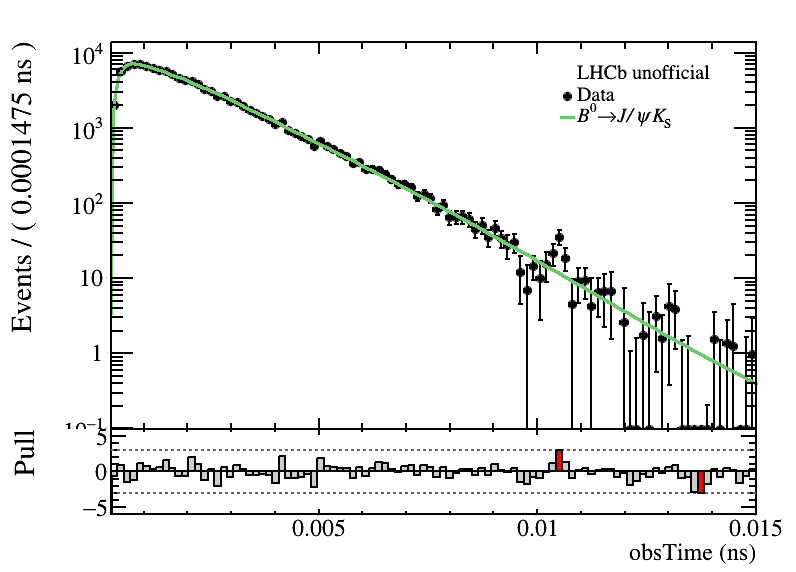

In [56]:
print('INFO: Start plotting', flush=True)
from ROOT import TColor
from root_utils.lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   

decay_set  = ROOT.RooArgSet(pdfDecayTime.getComponents().find('simPdf'))
ROOT.SetOwnership(decay_set, False)

# Prepare frame
canvas = TCanvas('canvas', 'canvas', 1000, 600)
ROOT.SetOwnership(canvas, False)

plot_frame = obsTime.frame(ROOT.RooFit.Range(0.00025, 0.015), ROOT.RooFit.Bins(100))
#plot_frame.SetMinimum(-100)

ROOT.SetOwnership(plot_frame, False)

data.plotOn(plot_frame, ROOT.RooFit.Name('data'))  
pdfDecayTime.plotOn(plot_frame, RooFit.ProjWData(RooArgSet(obsTimeErr ), data, True), RooFit.LineColor(410),ROOT.RooFit.Name('decay_fit'))

### Add additional informations to the plot
text_size = 0.05
# Create TLegend
legend = ROOT.TLegend(0.7, 0.7, 0.80, 0.85)
#legend = ROOT.TLegend(0.7, 0.30, 0.80, 0.5)
ROOT.SetOwnership(plot_frame, False)
legend.AddEntry(0,"LHCb unofficial", "")
legend.AddEntry(plot_frame.findObject('data'), 'Data', 'p')
legend.AddEntry(plot_frame.findObject('decay_fit'), '#it{B}^{0}#rightarrow#it{J/#psi}#it{K}_{#kern[-0.3]{S}}', 'l')
legend.SetTextSize(text_size)

plot_frame.GetYaxis().SetRangeUser(0.1, plot_frame.GetMaximum()*1.2)

# Plot pulls
plotname = 'decaytime_data_blinded_decrateCoeffs'
can,_ = plot_pulls(plotname, plot_frame, drawables=[legend], save_path= subdir + '/plots/', logy=True)
print('INFO: Finish plotting', flush=True)
can

In [50]:
parS.getError(),parS.getVal()

(0.03188597884219191, 0.7057364897066403)

In [51]:
parC.getError(),parC.getVal()

(0.029755613389385482, -0.16504265257112571)

### OS Tagger: B0 projection

INFO: Start plotting
INFO: Finish plotting


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: canvas
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


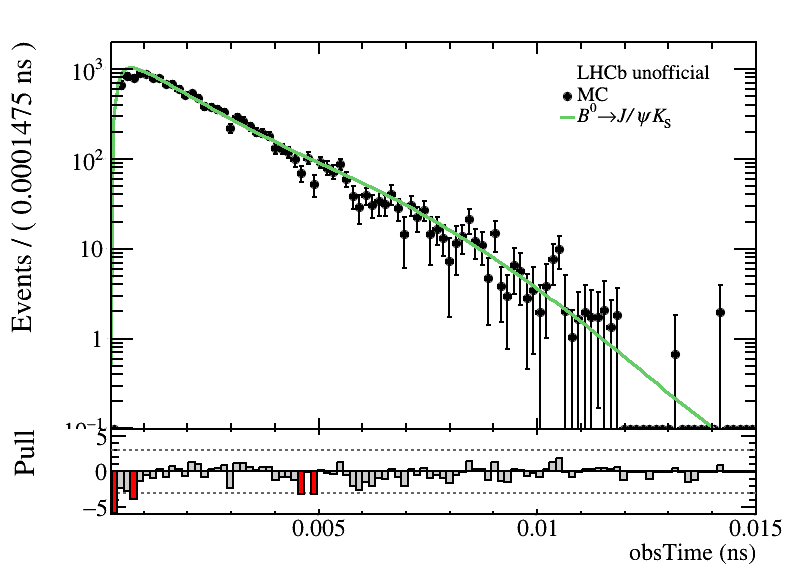

In [52]:
print('INFO: Start plotting', flush=True)
from ROOT import TColor
from root_utils.lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   

decay_set  = ROOT.RooArgSet(pdfDecayTime.getComponents().find('simPdf'))
ROOT.SetOwnership(decay_set, False)

# Prepare frame
canvas = TCanvas('canvas', 'canvas', 1000, 600)
ROOT.SetOwnership(canvas, False)

plot_frame = obsTime.frame(ROOT.RooFit.Range(0.00025, 0.015), ROOT.RooFit.Bins(100))
#plot_frame.SetMinimum(-100)

ROOT.SetOwnership(plot_frame, False)

#data.plotOn(plot_frame, ROOT.RooFit.Name('data'))  
data.plotOn(plot_frame, RooFit.Cut("B0_TAGDECISION_OS_new==B0_TAGDECISION_OS_new::B0"), ROOT.RooFit.Name('data'))  
#pdfDecayTime.plotOn(plot_frame, RooFit.ProjWData(RooArgSet(obsTimeErr), data, True), RooFit.LineColor(410),ROOT.RooFit.Name('decay_fit'))
pdfDecayTime.plotOn(plot_frame,RooFit.Slice(obsTagOS,"B0"), RooFit.ProjWData(RooArgSet(obsTimeErr), data, True), RooFit.LineColor(410),ROOT.RooFit.Name('decay_fit'))




### Add additional informations to the plot
text_size = 0.05
# Create TLegend
legend = ROOT.TLegend(0.7, 0.7, 0.80, 0.85)
#legend = ROOT.TLegend(0.7, 0.30, 0.80, 0.5)
ROOT.SetOwnership(plot_frame, False)
legend.AddEntry(0,"LHCb unofficial", "")
legend.AddEntry(plot_frame.findObject('data'), 'MC', 'p')
legend.AddEntry(plot_frame.findObject('decay_fit'), '#it{B}^{0}#rightarrow#it{J/#psi}#it{K}_{#kern[-0.3]{S}}', 'l')
legend.SetTextSize(text_size)

plot_frame.GetYaxis().SetRangeUser(0.1, plot_frame.GetMaximum()*1.2)

# Plot pulls
plotname = 'decaytime_data_blinded_decrateCoeffs_OS_B0'
can,_ = plot_pulls(plotname, plot_frame, drawables=[legend], save_path= subdir + '/plots/', logy=True)
print('INFO: Finish plotting', flush=True)
can

### OS Tagger: B0bar projection

INFO: Start plotting
INFO: Finish plotting


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: canvas
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


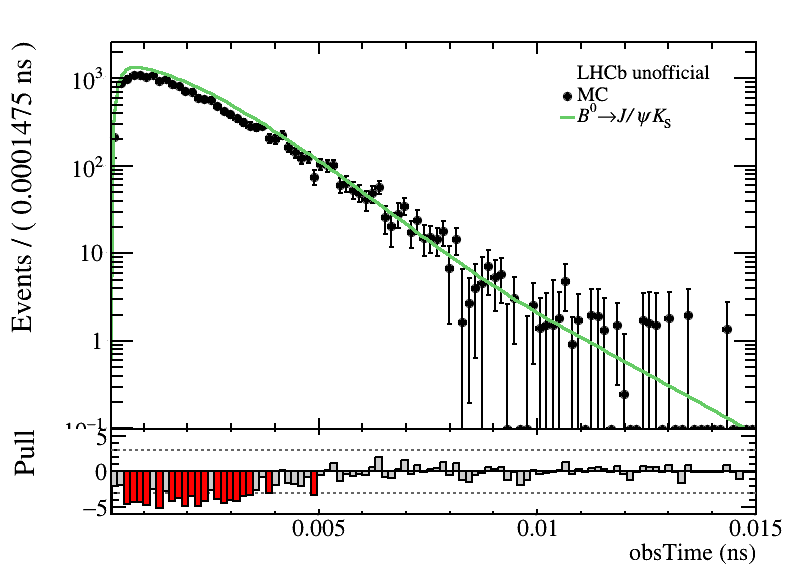

In [53]:
print('INFO: Start plotting', flush=True)
from ROOT import TColor
from root_utils.lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   

decay_set  = ROOT.RooArgSet(pdfDecayTime.getComponents().find('simPdf'))
ROOT.SetOwnership(decay_set, False)

# Prepare frame
canvas = TCanvas('canvas', 'canvas', 1000, 600)
ROOT.SetOwnership(canvas, False)

plot_frame = obsTime.frame(ROOT.RooFit.Range(0.00025, 0.015), ROOT.RooFit.Bins(100))
#plot_frame.SetMinimum(-100)

ROOT.SetOwnership(plot_frame, False)

#data.plotOn(plot_frame, ROOT.RooFit.Name('data'))  
data.plotOn(plot_frame, RooFit.Cut("B0_TAGDECISION_OS_new==B0_TAGDECISION_OS_new::B0b"), ROOT.RooFit.Name('data'))  
#pdfDecayTime.plotOn(plot_frame, RooFit.ProjWData(RooArgSet(obsTimeErr), data, True), RooFit.LineColor(410),ROOT.RooFit.Name('decay_fit'))
pdfDecayTime.plotOn(plot_frame,RooFit.Slice(obsTagOS,"B0b"), RooFit.ProjWData(RooArgSet(obsTimeErr), data, True), RooFit.LineColor(410),ROOT.RooFit.Name('decay_fit'))

### Add additional informations to the plot
text_size = 0.05
# Create TLegend
legend = ROOT.TLegend(0.7, 0.7, 0.80, 0.85)
#legend = ROOT.TLegend(0.7, 0.30, 0.80, 0.5)
ROOT.SetOwnership(plot_frame, False)
legend.AddEntry(0,"LHCb unofficial", "")
legend.AddEntry(plot_frame.findObject('data'), 'MC', 'p')
legend.AddEntry(plot_frame.findObject('decay_fit'), '#it{B}^{0}#rightarrow#it{J/#psi}#it{K}_{#kern[-0.3]{S}}', 'l')
legend.SetTextSize(text_size)

plot_frame.GetYaxis().SetRangeUser(0.1, plot_frame.GetMaximum()*1.2)

# Plot pulls
plotname = 'decaytime_data_blinded_decrateCoeffs_OS_B0b'
can,_ = plot_pulls(plotname, plot_frame, drawables=[legend], save_path= subdir + '/plots/', logy=True)
print('INFO: Finish plotting', flush=True)
can

### SS Tagger: B0 projection

In [54]:
print('INFO: Start plotting', flush=True)
from ROOT import TColor
from root_utils.lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   

decay_set  = ROOT.RooArgSet(pdfDecayTime.getComponents().find('simPdf'))
ROOT.SetOwnership(decay_set, False)

# Prepare frame
canvas = TCanvas('canvas', 'canvas', 1000, 600)
ROOT.SetOwnership(canvas, False)

plot_frame = obsTime.frame(ROOT.RooFit.Range(0.00025, 0.015), ROOT.RooFit.Bins(100))
#plot_frame.SetMinimum(-100)

ROOT.SetOwnership(plot_frame, False)

#data.plotOn(plot_frame, ROOT.RooFit.Name('data'))  
data.plotOn(plot_frame, RooFit.Cut("B0_TAGDECISION_SS_new==B0_TAGDECISION_SS_new::B0"), ROOT.RooFit.Name('data'))  
#pdfDecayTime.plotOn(plot_frame, RooFit.ProjWData(RooArgSet(obsTimeErr), data, True), RooFit.LineColor(410),ROOT.RooFit.Name('decay_fit'))
pdfDecayTime.plotOn(plot_frame,RooFit.Slice(obsTagSS,"B0"), RooFit.ProjWData(RooArgSet(obsTimeErr), data, True), RooFit.LineColor(410),ROOT.RooFit.Name('decay_fit'))

### Add additional informations to the plot
text_size = 0.05
# Create TLegend
legend = ROOT.TLegend(0.7, 0.7, 0.80, 0.85)
#legend = ROOT.TLegend(0.7, 0.30, 0.80, 0.5)
ROOT.SetOwnership(plot_frame, False)
legend.AddEntry(0,"LHCb unofficial", "")
legend.AddEntry(plot_frame.findObject('data'), 'MC', 'p')
legend.AddEntry(plot_frame.findObject('decay_fit'), '#it{B}^{0}#rightarrow#it{J/#psi}#it{K}_{#kern[-0.3]{S}}', 'l')
legend.SetTextSize(text_size)

plot_frame.GetYaxis().SetRangeUser(0.1, plot_frame.GetMaximum()*1.2)

# Plot pulls
plotname = 'decaytime_data_blinded_decrateCoeffs_SS_B0'
can,_ = plot_pulls(plotname, plot_frame, drawables=[legend], save_path= subdir + '/plots/', logy=True)
print('INFO: Finish plotting', flush=True)
can

INFO: Start plotting
ERROR: No RooCurve found! Will skip plotting...
INFO: Finish plotting


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: canvas
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can


0

### SS Tagger: B0bar projection

In [55]:
print('INFO: Start plotting', flush=True)
from ROOT import TColor
from root_utils.lhcb_style i1mport set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   

decay_set  = ROOT.RooArgSet(pdfDecayTime.getComponents().find('simPdf'))
ROOT.SetOwnership(decay_set, False)

# Prepare frame
canvas = TCanvas('canvas', 'canvas', 1000, 600)
ROOT.SetOwnership(canvas, False)

plot_frame = obsTime.frame(ROOT.RooFit.Range(0.00025, 0.015), ROOT.RooFit.Bins(100))
#plot_frame.SetMinimum(-100)

ROOT.SetOwnership(plot_frame, False)

#data.plotOn(plot_frame, ROOT.RooFit.Name('data'))  
data.plotOn(plot_frame, RooFit.Cut("B0_TAGDECISION_SS_new==B0_TAGDECISION_SS_new::B0b"), ROOT.RooFit.Name('data'))  
#pdfDecayTime.plotOn(plot_frame, RooFit.ProjWData(RooArgSet(obsTimeErr), data, True), RooFit.LineColor(410),ROOT.RooFit.Name('decay_fit'))
pdfDecayTime.plotOn(plot_frame,RooFit.Slice(obsTagSS,"B0b"), RooFit.ProjWData(RooArgSet(obsTimeErr), data, True), RooFit.LineColor(410),ROOT.RooFit.Name('decay_fit'))

### Add additional informations to the plot
text_size = 0.05
# Create TLegend
legend = ROOT.TLegend(0.7, 0.7, 0.80, 0.85)
#legend = ROOT.TLegend(0.7, 0.30, 0.80, 0.5)
ROOT.SetOwnership(plot_frame, False)
legend.AddEntry(0,"LHCb unofficial", "")
legend.AddEntry(plot_frame.findObject('data'), 'MC', 'p')
legend.AddEntry(plot_frame.findObject('decay_fit'), '#it{B}^{0}#rightarrow#it{J/#psi}#it{K}_{#kern[-0.3]{S}}', 'l')
legend.SetTextSize(text_size)

plot_frame.GetYaxis().SetRangeUser(0.1, plot_frame.GetMaximum()*1.2)

# Plot pulls
plotname = 'decaytime_data_blinded_decrateCoeffs_SS_B0b'
can,_ = plot_pulls(plotname, plot_frame, drawables=[legend], save_path= subdir + '/plots/', logy=True)
print('INFO: Finish plotting', flush=True)
can

SyntaxError: invalid syntax (<ipython-input-55-38e872e6fc7f>, line 3)